In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter
%matplotlib inline

Load a mean pulse profile for B1957+20

(-0.1, 0.8)

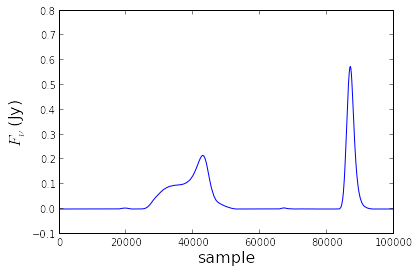

In [2]:
mean_profile = np.load('mean_profile.npy')

meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
meanprof_Jy[meanprof_Jy < 0] = 0
#mean_value = (np.mean(mean_profile) / np.median(mean_profile) - 1) * 12.

#print("Mean pulse flux = %s Jy" % (mean_value))

n = 100000
# 1 sample is 1/n*1.6ms

x = np.arange(1000)
profile = inter.interp1d(x, meanprof_Jy, kind='linear')
xnew = np.arange(0,x.size-1,(x.size-1.)/n)
meanprof_inter = profile(xnew)

plt.plot(meanprof_inter)
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$F_{\nu}$ (Jy)', fontsize=16)
#plt.xlim(0,1.6e-2)
plt.ylim(-.1, 0.8)

Isolate the main pulse, sqrt it, and center

(-0.1, 0.8)

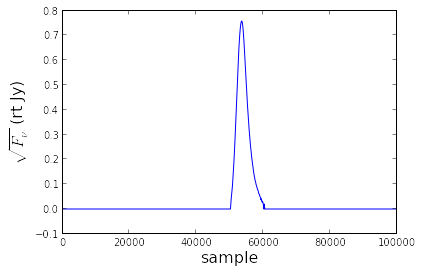

In [3]:
pulse = []

for i in np.arange(meanprof_inter.size):
    if (float(i) < n*830./1000. or float(i) > n*940./1000.):
        pulse.append(0)
    else:
        pulse.append(meanprof_inter[i])

pulse = np.sqrt(pulse)
pulse = np.roll(pulse, -n/3)

plt.plot(pulse)
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$\sqrt{F_{\nu}}$ (rt Jy)', fontsize=16)
#plt.xlim(0,1.6e-2)
plt.ylim(-.1, 0.8)

Invent some sinusoidal wave at frequency of observed band

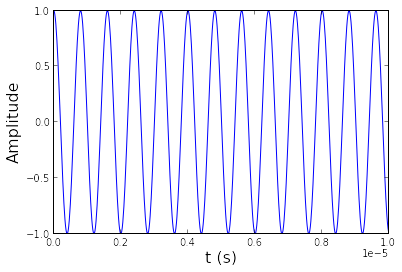

In [33]:
freq = 311.25 # MHz, observed band
p_spin = 1.6 # ms, spin period

freq *= 1e6 #Hz
p_spin *= 1e-3 #s

angular_freq = 2*np.pi*freq
t = np.linspace(0., p_spin, n)
phase = np.cos(angular_freq*t)
#why does np.sin start with a negative slope?? I'll use cos instead, and possibly switch to exponential later

plt.plot(t, phase)
plt.xlim(0, 1e-5)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'Amplitude', fontsize=16)

Compute an electric field

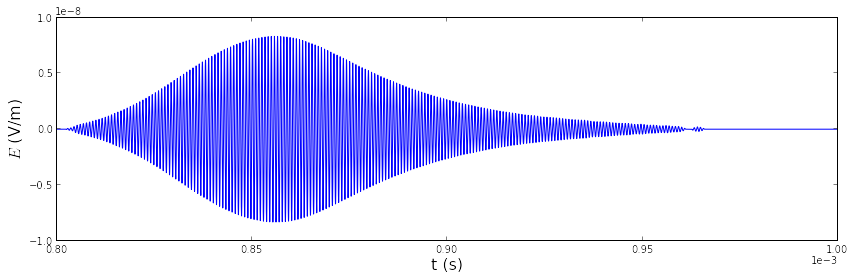

In [34]:
a = 109797  # rt(kg)*m/s^2/A; a = sqrt(2*16MHz/(c*n*epsilon_0)), conversion factor between
            # sqrt(Jansky) and E field strength assuming n=1 and a 16MHz bandwidth

b = 1e-13   # rt(kg)/s; a*b = 1.1e-8 V/m

E_field = a*b*pulse*phase

plt.figure(figsize=(14,4))
plt.plot(t, E_field)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlim(0.8e-3,1e-3)
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'$E$ (V/m)', fontsize=16)

125.502008032


(0, 101)

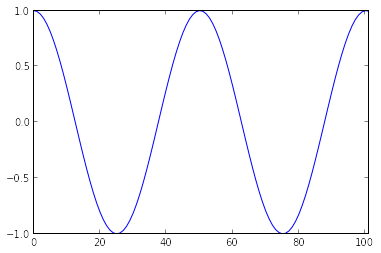

In [43]:
# x in the following functions should be in s

p_phase = 1./(freq) # s, E field oscillation period
R = 6.273 # s, pulsar-companion distance

def tau_str(x):
    return 1e-5 #s
def tau_geom(x):
    return x**2/(2*R)
def tau_phase(x):
    return -tau_str(x) + tau_geom(x)
def tau_group(x):
    return tau_str(x) + tau_geom(x)

print n/(freq*p_spin**2)
plt.plot(phase)
plt.xlim(0,101)